In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='svg'

import numpy as np
np.set_printoptions(precision=6, suppress=True)
np.set_printoptions(threshold=np.inf)

import shl_scripts.shl_tools
from shl_scripts.shl_experiments import SHL

import DNN.mnist_loader as data_loader
import DNN.network as network
from shl_scripts.shl_encode import sparse_encode

In [2]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data,validation_data,test_data = data_loader.load_data()
training_image = training_data[0]
training_supervision = training_data[1]
test_image = test_data[0]
test_supervision = test_data[1]

In [4]:
tag ='2017-06-01_MNIST_MEUL_DEBUG_'
DEBUG_DOWNSCALE, verbose = 10, 10
tag ='2017-06-01_MNIST_MEUL_'
DEBUG_DOWNSCALE, verbose = 1, 10
patch_size = (28,28)
n_dictionary = 15**2
l0_sparseness = 7
n_iter = 2**14
eta = 0.01
eta_homeo = 0.01
verbose = 0
list_figures=['show_dico']
n_hidden = 100

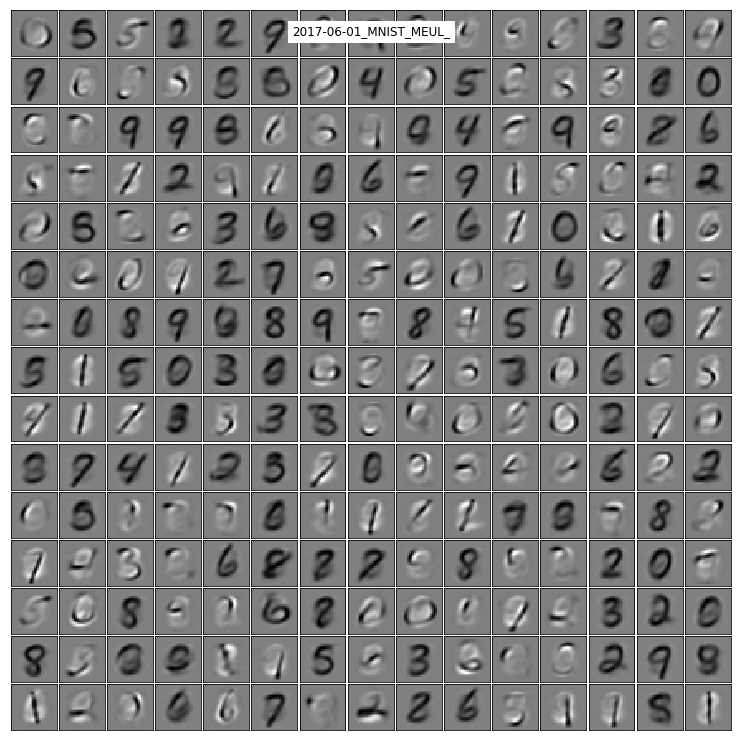

In [5]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
            eta=eta, eta_homeo=eta_homeo, verbose=verbose,
            n_iter=n_iter, patch_size=patch_size, l0_sparseness=l0_sparseness,
            n_dictionary=n_dictionary)
matname = tag
dico = shl.learn_dico(data=training_image, matname=matname,list_figures=list_figures)    
## formating the date to fit theano standard
training_sparse_vector = shl.code(data=training_image, dico=dico, matname=matname)

test_sparse_vector = sparse_encode(test_image, dico.dictionary, algorithm = shl.learning_algorithm,
                        l0_sparseness = l0_sparseness, fit_tol = None,
                        P_cum = dico.P_cum, verbose = 0)
wrapped_training_data = (training_sparse_vector, training_supervision)
wrapped_test_data = (test_sparse_vector, test_supervision)

wrapped_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_training_data[0]]
wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
wrapped_training_data = zip(wrapped_inputs, wrapped_results)
wrapped_test_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_test_data[0]]
wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])

In [6]:
list(wrapped_test_data_final)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [7]:
2**np.arange(4, 8)

array([ 16,  32,  64, 128])

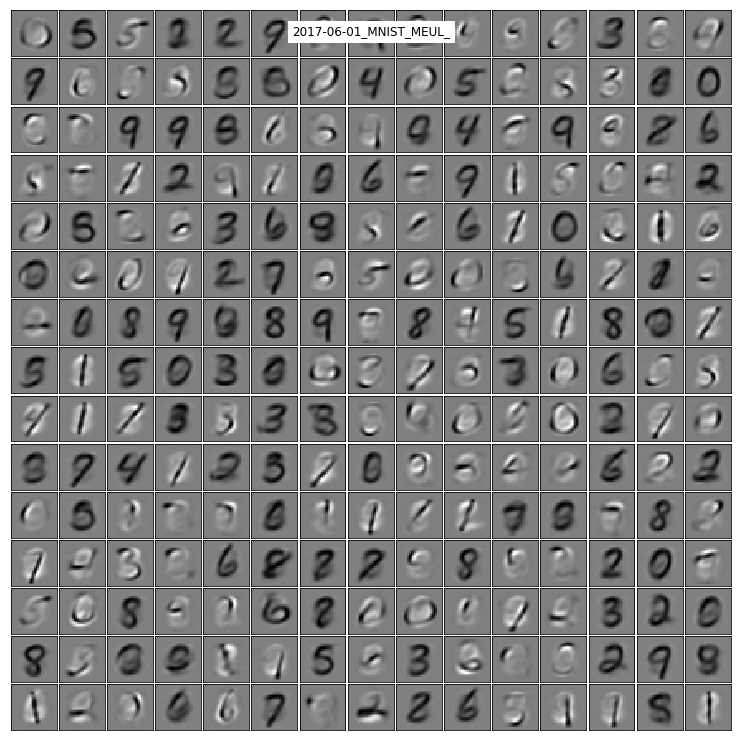

In [8]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
            eta=eta, eta_homeo=eta_homeo, verbose=verbose,
            n_iter=n_iter, patch_size=patch_size, l0_sparseness=l0_sparseness,
            n_dictionary=n_dictionary)
matname = tag
dico = shl.learn_dico(data=training_image, matname=matname, list_figures=list_figures)    


In [9]:
def format_data(matname):
    training_sparse_vector = shl.code(data=training_image, dico=dico, matname=matname)
    test_sparse_vector = shl.code(data=test_image, dico=dico, matname=matname)
    #sparse_encode(test_image, dico.dictionary, algorithm = shl.learning_algorithm,
    #                        l0_sparseness=l0_sparseness, fit_tol = None,
    #                        P_cum = dico.P_cum, verbose = 0)
    wrapped_training_data = (training_sparse_vector, training_supervision)
    wrapped_test_data = (test_sparse_vector, test_supervision)

    wrapped_inputs = [np.reshape(x, (n_dictionary, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (n_dictionary, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])
    n_test = len(wrapped_test_inputs)
    return wrapped_test_data_final, n_test

In [10]:
wrapped_test_data_final, n_test = format_data(matname)
net=network.Network([shl.n_dictionary, n_hidden, 10])
net.SGD(training_data=wrapped_training_data,
   epochs=30,
   mini_batch_size=10,
   eta=.3)

In [11]:
print( 'Result = ', net.evaluate(wrapped_test_data_final) / len(wrapped_test_inputs))

Result =  0.0987


In [12]:
net.evaluate(wrapped_test_data_final), len(wrapped_test_inputs)

(0, 10000)

 ----- learning with eta_ : 0.1 -----
 ----- learning with eta_ : 0.1778279410038923 -----
 ----- learning with eta_ : 0.31622776601683794 -----
 ----- learning with eta_ : 0.5623413251903491 -----
 ----- learning with eta_ : 1.0 -----
 ----- learning with eta_ : 1.7782794100389228 -----
 ----- learning with eta_ : 3.1622776601683795 -----
 ----- learning with eta_ : 5.623413251903491 -----
 ----- learning with eta_ : 10.0 -----


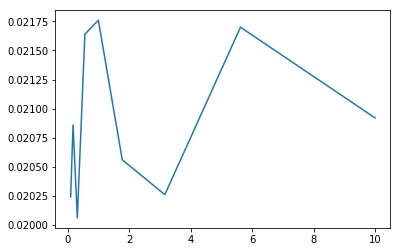

In [13]:
etas = np.logspace(-1, 1, 9, base=10)

results = []
for eta_ in etas:
    print(" ----- learning with eta_ : {} -----".format(eta_))
    wrapped_test_data_final, n_test = format_data(matname)

    ## running the network
    net=network.Network([shl.n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=eta_)
    results.append(net.evaluate(wrapped_test_data_final) / n_test)

plt.plot(etas, results)

 ----- learning with n_hidden : 16 -----
 ----- learning with n_hidden : 32 -----
 ----- learning with n_hidden : 64 -----
 ----- learning with n_hidden : 128 -----


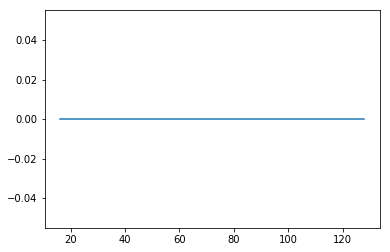

In [14]:
n_hiddens = 2**np.arange(4, 8)
results = []
for n_hidden_ in n_hiddens:
    print(" ----- learning with n_hidden : {} -----".format(n_hidden_))
    ## running the network
    net=network.Network([shl.n_dictionary, n_hidden_, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0)
    results.append(net.evaluate(wrapped_test_data_final) / n_test)

plt.plot(n_hiddens, results)

 ----- learning with mini_batch_size : 16 -----
 ----- learning with mini_batch_size : 32 -----
 ----- learning with mini_batch_size : 64 -----
 ----- learning with mini_batch_size : 128 -----


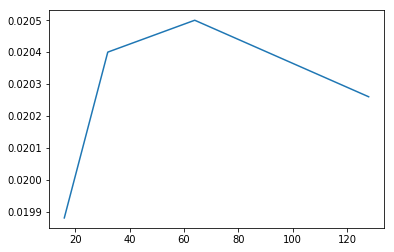

In [15]:
mini_batch_sizes = 2**np.arange(4, 8)
results = []
for mini_batch_size_ in mini_batch_sizes:
    print(" ----- learning with mini_batch_size : {} -----".format(mini_batch_size_))
    wrapped_test_data_final, n_test = format_data(matname)
    ## running the network
    net=network.Network([shl.n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=mini_batch_size_,
       eta=3.0)
    results.append(net.evaluate(wrapped_test_data_final) / n_test)

plt.plot(mini_batch_sizes, results)

 ----- learning with epochs : 16 -----
 ----- learning with epochs : 32 -----
 ----- learning with epochs : 64 -----
 ----- learning with epochs : 128 -----


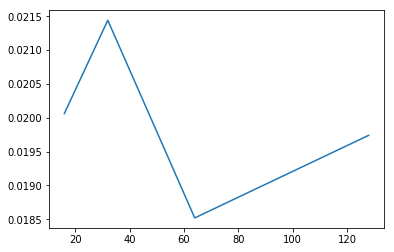

In [16]:
epochss = 2**np.arange(4, 8)
results = []
for epochs_ in epochss:
    print(" ----- learning with epochs : {} -----".format(epochs_))
    wrapped_test_data_final, n_test = format_data(matname)
    ## running the network
    net=network.Network([shl.n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=epochs_,
       mini_batch_size=10,
       eta=3.0)
    results.append(net.evaluate(wrapped_test_data_final) / n_test)

plt.plot(epochss, results)

In [17]:
results


[0.02006, 0.02144, 0.01852, 0.01974]